In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/My Drive/SemSeg'

/content/drive/My Drive/SemSeg


In [3]:
#!unzip archive.zip

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.utils.data as data
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy import ndimage
from dataloader import *
from utils import *
from models.unet import *

In [5]:
#def c2g(colors):
#  cn = np.reshape(colors, (1,1,3))
#  cn = cv2.cvtColor(cn, cv2.COLOR_BGR2GRAY)
#  return cn
# Pixel classes
colors = np.array([[0,0,0], [111,74,0], [81,0,81], [128,64,128], [244, 35, 232]
                   ,[250, 170, 160], [230, 150, 140], [70,70,70], [102,102, 156]
                   , [190, 153, 153], [180, 165, 180], [150, 100, 100]
                   , [150, 120, 90], [153, 153, 153], [250, 170, 30], [220, 220, 0]
                   , [107, 142, 35], [152, 251, 152], [70, 130, 180], [220, 20, 60]
                   , [255, 0, 0], [0, 0, 142], [0, 0, 70], [0, 60, 100], [0, 0, 90]
                   , [0, 0, 110], [0, 80, 100], [0, 0, 230], [119, 11, 32], [0, 0, 142]], dtype = np.uint8)
colors = c2g(colors, grayscale = True)

In [ ]:
colors

In [7]:
# Perform Data Loading

transform_img = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
transform_label = transforms.Compose([transforms.ToTensor()])

In [8]:
os.getcwd()

'/content/drive/My Drive/SemSeg'

In [9]:
trainset = train(transform_img, os.path.join(os.getcwd(),'CamVid/train'),
                 os.path.join(os.getcwd(), 'CamVid/train_labels'),transform_label, colors)

In [10]:
valset = validation(transform_img, os.path.join(os.getcwd(),'CamVid/val'),
                 os.path.join(os.getcwd(), 'CamVid/val_labels'),transform_label, colors)

In [11]:
testset = test(transform_img, os.path.join(os.getcwd(),'CamVid/test'),
                 os.path.join(os.getcwd(), 'CamVid/test_labels'),transform_label, colors)

In [12]:
train_loader = data.DataLoader(trainset, batch_size = 1, shuffle = True, num_workers = 4)
val_loader = data.DataLoader(valset, batch_size = 1, shuffle = True, num_workers = 4)
test_loader = data.DataLoader(testset, batch_size = 1, shuffle = True, num_workers = 4)

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [14]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [15]:
UNET = UNet()
UNET.to(device)

UNet(
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_conv_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_conv_4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_conv_5): Sequential(
    (0): Conv2d(512, 1024, kernel_size

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(UNET.parameters(), lr = 0.001, betas = (0.9, 0.999), eps = 1e-08, weight_decay = 0, amsgrad = False)

In [ ]:
#import os
#os._exit(00)

In [ ]:
#UNET = torch.load(os.path.join(os.getcwd(), unet20.pth))

In [ ]:
train_loss = []
val_loss = []
epochs = 100
for ep in range(epochs):
  UNET.train()
  running_loss = 0.0
  counter = 0
  for i, data in enumerate(train_loader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    if labels.size() == torch.Size([1, 1, 388, 388]):
      labels = labels.reshape(1, 388, 388)
    optimizer.zero_grad()
    outputs = UNET(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss = running_loss + loss.item()
    counter = counter + 1
  epoch_loss = running_loss/counter
  print('Epoch {}/{}, {} Loss: {:.4f}'.format(ep, epochs, 'Training', epoch_loss))
  train_loss = train_loss + [epoch_loss]
  UNET.eval()
  running_loss = 0.0
  counter = 0
  for i, data in enumerate(val_loader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    if labels.size() == torch.Size([1, 1, 388, 388]):
      labels = labels.reshape(1, 388, 388)
    optimizer.zero_grad()
    outputs = UNET(inputs)
    loss = criterion(outputs, labels)
    running_loss = running_loss + loss.item()
    counter = counter + 1
  epoch_loss = running_loss/counter
  print('Epoch {}/{}, {} Loss: {:.4f}'.format(ep, epochs, 'Validation', epoch_loss))
  val_loss = val_loss + [epoch_loss]
  if ep%10 == 0:
    print("Saving Model after epoch {}".format(ep))
    torch.save(UNET.state_dict(), os.path.join(os.getcwd(), 'unet{}.pth'.format(ep)))

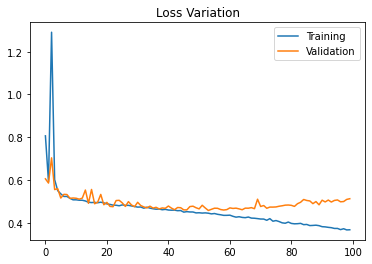

In [ ]:
plt.plot(train_loss, label = 'Training')
plt.plot(val_loss, label = 'Validation')
plt.title("Loss Variation")
plt.legend()
plt.show()

It turns out that overfitting had started after epoch 50. Therefore, using the weights saved at that point.

In [ ]:
%ls

archive.zip  unet0.pth   unet30.pth  unet60.pth  unet90.pth
CamVid/      unet10.pth  unet40.pth  unet70.pth  unet.ipynb
Copy.ipynb   unet20.pth  unet50.pth  unet80.pth  UNet.ipynb


In [ ]:
colors = np.array([[0,0,0], [111,74,0], [81,0,81], [128,64,128], [244, 35, 232]
                   ,[250, 170, 160], [230, 150, 140], [70,70,70], [102,102, 156]
                   , [190, 153, 153], [180, 165, 180], [150, 100, 100]
                   , [150, 120, 90], [153, 153, 153], [250, 170, 30], [220, 220, 0]
                   , [107, 142, 35], [152, 251, 152], [70, 130, 180], [220, 20, 60]
                   , [255, 0, 0], [0, 0, 142], [0, 0, 70], [0, 60, 100], [0, 0, 90]
                   , [0, 0, 110], [0, 80, 100], [0, 0, 230], [119, 11, 32], [0, 0, 142]], dtype = np.uint8)
colors = c2g(colors, grayscale = False)

In [ ]:
colors

[array([[[0, 0, 0]]], dtype=uint8),
 array([[[111,  74,   0]]], dtype=uint8),
 array([[[81,  0, 81]]], dtype=uint8),
 array([[[128,  64, 128]]], dtype=uint8),
 array([[[244,  35, 232]]], dtype=uint8),
 array([[[250, 170, 160]]], dtype=uint8),
 array([[[230, 150, 140]]], dtype=uint8),
 array([[[70, 70, 70]]], dtype=uint8),
 array([[[102, 102, 156]]], dtype=uint8),
 array([[[190, 153, 153]]], dtype=uint8),
 array([[[180, 165, 180]]], dtype=uint8),
 array([[[150, 100, 100]]], dtype=uint8),
 array([[[150, 120,  90]]], dtype=uint8),
 array([[[153, 153, 153]]], dtype=uint8),
 array([[[250, 170,  30]]], dtype=uint8),
 array([[[220, 220,   0]]], dtype=uint8),
 array([[[107, 142,  35]]], dtype=uint8),
 array([[[152, 251, 152]]], dtype=uint8),
 array([[[ 70, 130, 180]]], dtype=uint8),
 array([[[220,  20,  60]]], dtype=uint8),
 array([[[255,   0,   0]]], dtype=uint8),
 array([[[  0,   0, 142]]], dtype=uint8),
 array([[[ 0,  0, 70]]], dtype=uint8),
 array([[[  0,  60, 100]]], dtype=uint8),
 array(

In [ ]:
def testing(image, colors):
  class_pix = np.ones([388,388,3], dtype = np.uint8)
  for index, c in enumerate(colors):
    class_pix[image == index] = c
  return class_pix.reshape((388,388,3))

In [ ]:
inputs, labels = next(iter(test_loader))

In [ ]:
inputs, labels = inputs.to(device), labels.to(device)

In [ ]:
UNET = UNet()

In [ ]:
UNET.load_state_dict(torch.load(os.path.join(os.getcwd(), 'unet50.pth')))

<All keys matched successfully>

In [ ]:
UNET.to(device)

In [ ]:
outputs = UNET(inputs)

# Jaccard Index Metric

In [ ]:
IOUf = 0
count = 0
for i, data in enumerate(test_loader):
  inputs, labels = data
  inputs = inputs.to(device)
  outputs = UNET(inputs)
  outputs = outputs.cpu()
  outputs = outputs.detach().numpy()
  outputs = outputs.argmax(axis = 1)
  if labels.size() == torch.Size([outputs.shape[0], 1, 388, 388]):
    labels = labels.detach().numpy()
    labels = labels.reshape(outputs.shape[0], 388, 388)
  outputs = outputs.reshape(outputs.shape[0], 388, 388)
  for k in range(outputs.shape[0]):
    o = outputs[k, :, :]
    l = labels[k, :, :]
    IOU = 0
    for c in range(32):
      intersection = 0
      union = 0
      f = c * np.ones((1,388,388))
      i = (o == c) * 1
      j = (l == c) * 1
      inte = 0
      for x in range(388):
        for y in range(388):
          if i[x,y] == j[x,y] and i[x,y] == 1:
            inte = inte + 1
      intersection = intersection + inte
      union = union + ((f == l) * 1).sum() + ((f == o) * 1).sum() - inte
      if union == 0:
        continue
      IOUc = intersection/union
      IOU = IOU + IOUc
    count = count + 1
    IOU = IOU/32
  IOUf = IOUf + IOU

In [ ]:
print("IoU: ", IOUf/count)

IoU:  0.04023583756305232


In [ ]:
inputs, labels = next(iter(test_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


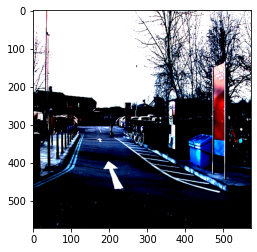

In [ ]:
plt.imshow(ndimage.rotate(np.squeeze(inputs.numpy()).transpose(2,1,0), 270), cmap = 'gray')

In [ ]:
inputs = inputs.to(device)
outputs = UNET(inputs)

In [ ]:
outputs = outputs.cpu()
outputs = outputs.detach().numpy()
outputs = outputs.argmax(axis = 1)

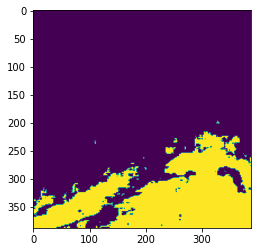

In [ ]:
plt.imshow(outputs[0])